<a href="https://colab.research.google.com/github/isa-ulisboa/sig/blob/main/fast_ai_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting survival of Titanic passengers

Works with fastai version 2.7.11

In [79]:
#!pip install -q fastai --upgrade



In [80]:
import fastai
print(fastai.__version__)

2.7.12


In [81]:
from fastai import *
from fastai.tabular.all import *
import pandas as pd

In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load data

In [83]:
train_df = pd.read_csv('/content/drive/MyDrive/AAA/Lesson_5/titanic_data/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/AAA/Lesson_5/titanic_data/test.csv')
print(train_df.shape,test_df.shape)
train_df.head()

(891, 12) (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Feature engineering
- Extract *Title* from the name colum. 
- Extract *Deck* from the first character of the cabin number.
- Fill in missing *Age* values with the mean age for passengers with the same title.

In [84]:
for df in [train_df, test_df]:
    df['Title'] = df['Name'].str.split(',').str[1].str.split(' ').str[1]
    df['Deck'] = df['Cabin'].str[0]

# find mean age for each Title across train and test data sets
all_df = pd.concat([train_df, test_df], sort=False)
mean_age_by_title = all_df.groupby('Title').mean()['Age']
# update missing ages
for df in [train_df, test_df]:
    for title, age in mean_age_by_title.iteritems():
        df.loc[df['Age'].isnull() & (df['Title'] == title), 'Age'] = age

<ipython-input-84-dcf17dc8baed>:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_age_by_title = all_df.groupby('Title').mean()['Age']
<ipython-input-84-dcf17dc8baed>:10: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for title, age in mean_age_by_title.iteritems():


In [85]:
test_df.Fare.fillna(0,inplace=True)

In [86]:
train_df.shape

(891, 14)


## Fastai setup

In [87]:
dep_var = 'Survived'
cat_names = ['Pclass', 'Sex', 'Embarked', 'Title', 'Deck']
cont_names = ['Age', 'Fare', 'SibSp', 'Parch']
procs = [FillMissing,Categorify, Normalize] #, 

The last part is the list of pre-processors we apply to our data:

1. `Categorify` is going to take every categorical variable and make a map from integer to unique categories, then replace the values by the corresponding index.
2. `FillMissing` will fill the missing values in the continuous variables by the median of existing values (you can choose a specific value if you prefer)
3. `Normalize` will normalize the continuous variables (subtract the mean and divide by the std)


In [88]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names=cat_names ,
                   cont_names = cont_names,
                   y_names=dep_var,
                   splits=splits,
                   y_block = CategoryBlock) # when y's are 0/1 but we don't want to do regression
dls = to.dataloaders(bs=64) # dataloaders

In [108]:
to.train.items['Title']

188    12
333    12
203    12
40     13
273    12
       ..
278     8
393     9
609     9
166    13
7       8
Name: Title, Length: 713, dtype: int8

Build learner, which is a multi-layer neural network, and includes layers for categorical embedding.

In [89]:
learn = tabular_learner(dls, metrics=accuracy)

`learn.model` does a preview of the model. `LinBnDrop` is a module grouping three components: `BatchNorm1d`, `Dropout` and Linear layers

In [90]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(4, 3)
    (1): Embedding(3, 3)
    (2): Embedding(4, 3)
    (3): Embedding(18, 8)
    (4): Embedding(9, 5)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=26, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=200, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=2, bias=True)
    )
  )
)

### Let's look at the categorical embedding part of the network:

For fundamentals, see paper "Entity Embeddings of Categorical Variables" https://arxiv.org/abs/1604.06737. 

In [91]:
print(cat_names)
print('number categories for Title:',len(train_df['Title'].unique()),train_df['Title'].unique()) # same as list(train_df['Title'].astype('category').cat.categories.values)
print('number categories for Deck:',len(train_df['Deck'].unique()),train_df['Deck'].unique())
print(learn.model.embeds) # one row per categorial variable Notice that: cat_names = ['Pclass', 'Sex', 'Embarked', 'Title', 'Deck']

['Pclass', 'Sex', 'Embarked', 'Title', 'Deck']
number categories for Title: 17 ['Mr.' 'Mrs.' 'Miss.' 'Master.' 'Don.' 'Rev.' 'Dr.' 'Mme.' 'Ms.' 'Major.'
 'Lady.' 'Sir.' 'Mlle.' 'Col.' 'Capt.' 'the' 'Jonkheer.']
number categories for Deck: 9 [nan 'C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']
ModuleList(
  (0): Embedding(4, 3)
  (1): Embedding(3, 3)
  (2): Embedding(4, 3)
  (3): Embedding(18, 8)
  (4): Embedding(9, 5)
)


Method `lr_find` helps to find a good learning rate. 

SuggestedLRs(valley=0.0020892962347716093)

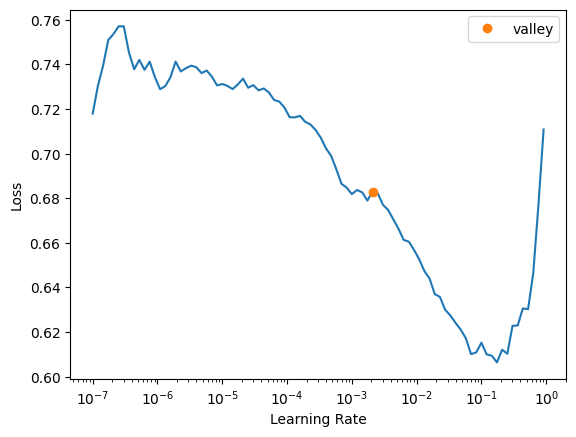

In [92]:
learn.lr_find()

In [93]:
learn.fit_one_cycle(12, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.670569,0.645198,0.640449,00:00
1,0.631898,0.616335,0.662921,00:00
2,0.580406,0.528923,0.769663,00:00
3,0.536961,0.521643,0.747191,00:00
4,0.504223,0.457481,0.758427,00:00
5,0.472722,0.492035,0.769663,00:00
6,0.449708,0.486721,0.780899,00:00
7,0.433321,0.464275,0.792135,00:00
8,0.415426,0.494111,0.786517,00:00
9,0.401674,0.474078,0.780899,00:00


### Replace each categorical value with its embedding vector

In [98]:
learn.dls.cat_names
learn.model.embeds[0]
to.train.xs

,Pclass,Sex,Embarked,Title,Deck,Age,Fare,SibSp,Parch
188,3,2,2,12,0,0.805648,-0.352836,0.473061,0.753662
333,3,2,3,12,0,-1.013980,-0.299798,1.409986,-0.478818
203,3,2,1,12,0,1.222646,-0.528389,-0.463863,-0.478818
40,3,1,3,13,0,0.805648,-0.480656,0.473061,-0.478818
273,1,2,1,12,3,0.578194,-0.051583,-0.463863,0.753662
...,...,...,...,...,...,...,...,...,...
278,3,2,2,8,0,-1.696341,-0.063782,3.283834,0.753662
393,1,1,1,9,4,-0.483255,1.721456,0.473061,-0.478818
609,1,1,3,9,3,0.805648,2.574032,-0.463863,-0.478818
166,1,1,3,13,5,0.577749,0.485155,-0.463863,0.753662


In [94]:
# from https://towardsdatascience.com/entity-embeddings-for-ml-2387eb68e49
def embed_features(learner, xs):
  """
  learner: fastai Learner used to train the neural net
  xs: DataFrame containing input variables. Categorical values are defined by their rank. 
 ::return:: copy of `xs` with embeddings replacing each categorical variable
  """
  xs = xs.copy()
  for i,col in enumerate(learn.dls.cat_names):
    
    # get matrix containing each row's embedding vector
    emb = learn.model.embeds[i]
    emb_data = emb(tensor(xs[col], dtype=torch.int64))
    emb_names = [f'{col}_{j}' for j in range(emb_data.shape[1])]
    
    # join the embedded category and drop the old feature column
    feat_df = pd.DataFrame(data=emb_data, index=xs.index,               
                           columns=emb_names)
    xs = xs.drop(col, axis=1)
    xs = xs.join(feat_df)
  return xs


     Pclass_0  Pclass_1  Pclass_2     Sex_0     Sex_1     Sex_2  Embarked_0  \
548  0.026924 -0.059794 -0.089158 -0.021211 -0.062563 -0.036905    0.046291   
810  0.026924 -0.059794 -0.089158 -0.021211 -0.062563 -0.036905    0.046291   
179  0.026924 -0.059794 -0.089158 -0.021211 -0.062563 -0.036905    0.046291   

     Embarked_1  Embarked_2   Title_0  ...   Title_3   Title_4   Title_5  \
548   -0.018686   -0.062492  0.064351  ...  0.054455 -0.062777 -0.012065   
810   -0.018686   -0.062492  0.064351  ...  0.054455 -0.062777 -0.012065   
179   -0.018686   -0.062492  0.064351  ...  0.054455 -0.062777 -0.012065   

      Title_6   Title_7    Deck_0    Deck_1    Deck_2    Deck_3    Deck_4  
548 -0.041705 -0.062046  0.024757 -0.008766 -0.044534 -0.029898  0.004385  
810 -0.041705 -0.062046  0.024757 -0.008766 -0.044534 -0.029898  0.004385  
179 -0.041705 -0.062046  0.024757 -0.008766 -0.044534 -0.029898  0.004385  

[3 rows x 22 columns]
    Pclass     Sex Embarked  Title Deck
10       3 

In [ ]:
# show embeddings and raw (original) variables
emb_train_xs = embed_features(learn, to.train.xs)
emb_valid_xs = embed_features(learn, to.valid.xs)
print(emb_train_xs.iloc[10:13,~emb_train_xs.columns.isin(cont_names)]) # embeddings
print(train_df.iloc[10:13][cat_names]) # original variables

In [148]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import seaborn as sns
titleCols=[x for x in emb_xs.columns if 'Title' in x]
X=array(emb_train_xs[titleCols])
y=array(to.train.items['Title'])
Z=np.concatenate((X,np.reshape(y, (X.shape[0], 1))),axis=1)
Z=np.unique(Z, axis=0)
X=Z[:, :-1]
print(X.shape)
y=Z[:,-1]
print(y.shape)
target_names=train_df['Title'].unique()
colors = sns.color_palette(None, len(target_names))
lda = LinearDiscriminantAnalysis(n_components=2)
X_r = lda.fit(X, y).transform(X)
lw = 2
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of Title')
plt.show()


(13, 8)
(13,)


ValueError: ignored

In [144]:
X

array([-0.07104684, -0.05394547, -0.04146624, -0.00495211, -0.00225844,
        0.00697421,  0.01212738,  0.03180639,  0.05471003,  0.06435076],
      dtype=float32)

In [149]:
X.round(3)

array([[-0.071, -0.029,  0.066, -0.07 ,  0.074, -0.008,  0.081,  0.058],
       [-0.064, -0.033,  0.058, -0.051,  0.049, -0.016,  0.045,  0.022],
       [-0.054, -0.06 ,  0.033, -0.063,  0.056, -0.004,  0.031,  0.059],
       [-0.053, -0.024,  0.038, -0.047,  0.027,  0.016, -0.012,  0.029],
       [-0.041, -0.044,  0.033, -0.035,  0.054, -0.009, -0.013,  0.042],
       [-0.005, -0.041,  0.032, -0.006,  0.025,  0.018, -0.011,  0.043],
       [ 0.02 ,  0.02 ,  0.017,  0.007,  0.011, -0.016,  0.014,  0.006],
       [ 0.029,  0.043, -0.052,  0.054, -0.045,  0.055, -0.039, -0.043],
       [ 0.032,  0.034, -0.055,  0.057, -0.053,  0.048, -0.041, -0.059],
       [ 0.053,  0.03 , -0.035,  0.064, -0.044,  0.07 , -0.046, -0.067],
       [ 0.055,  0.028, -0.04 ,  0.052, -0.069, -0.004, -0.057, -0.054],
       [ 0.064,  0.033, -0.067,  0.054, -0.063, -0.012, -0.042, -0.062],
       [ 0.069,  0.074, -0.089,  0.109, -0.106,  0.023, -0.068, -0.089]],
      dtype=float32)

In [150]:
y.round(0)

array([13., 14.,  8., 10.,  9., 11.,  7.,  5.,  4.,  1.,  2., 12., 15.],
      dtype=float32)

In [142]:
Z=np.concatenate((X,np.reshape(y, (X.shape[0], 1))),axis=1)
np.unique(Z, axis=0)

array([[-7.1046837e-02, -2.8997768e-02,  6.5503955e-02, -6.9798924e-02,
         7.4058205e-02, -7.5806021e-03,  8.1317104e-02,  5.8215998e-02,
         1.3000000e+01],
       [ 6.4350761e-02,  3.3170056e-02, -6.6726126e-02,  5.4454848e-02,
        -6.2776990e-02, -1.2065493e-02, -4.1705027e-02, -6.2045962e-02,
         1.2000000e+01]], dtype=float32)

In [138]:
np.reshape(y, (X.shape[0], 1))


array([[12],
       [13],
       [13],
       [12],
       [13],
       [12],
       [12],
       [13],
       [12],
       [13],
       [12],
       [12],
       [12],
       [13],
       [12],
       [12],
       [12],
       [12],
       [13],
       [12]], dtype=int8)

In [139]:
X.shape

(20, 8)